## Notebook Setup

### Import the required packages.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from flaml import AutoML
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from flaml.automl.ml import sklearn_metric_loss_score

### Plotting Functions

In [3]:
def reg_model_metrics(actual, pred):
    MSE = mean_squared_error(actual, pred) # root mean squared error
    RMSE = np.sqrt(MSE) # root mean squared error
    actual_mean = np.mean(actual) # calculate the mean for use below
    RRMSE = 100 * RMSE / actual_mean # relative root mean squared error
    R2 = r2_score(actual, pred) # coefficient of determination
    return RMSE, RRMSE, R2

def scatter_plot(y_test, y_pred_test, title):
  # Use the model metrics function to calculate RMSE, RRMSE, and R2
    RMSE, RRMSE, R2 = reg_model_metrics(y_test, y_pred_test)
  # Initialize the figure and axis
    fig,ax = plt.subplots(dpi=350)
  # Scatter the y_test vs y_pred_testicted values
    ax.scatter(y_test, y_pred_test, edgecolors=(0,0,0))
  # Plot the line of perfect fir
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
  # Make a few pieces of text that give the values of R2, RMSE, and RRMSE
    text = r"R2 = %.2f" % (R2);text += "\n"; text += r"RMSE = %.2f" % (RMSE); text += "\n"
    text += r"RRMSE = %.2f" % (RRMSE) +'%'
  # Add the text values to a plot at a particular place on the axis within a box
    plt.annotate(text, xy=(0.05, 0.85), xycoords='axes fraction',color='black', fontsize=10,
                 bbox=dict(facecolor='none',edgecolor='red'))
  # Set the x-axis label
    ax.set_xlabel('Actual Average AR IVT')
  # Set the y-axis label
    ax.set_ylabel('Predicted Average AR IVT')
  # Set the plot title
    ax.set_title(title)
  # Set the background color
    fig.patch.set_facecolor('white')
  # Show the plot
    plt.show()

#### Data Preprocessing

In [4]:
#
# Read the atmospheric river teleconnection pattern dataframe
ar_tcp = pd.read_csv("C:/Users/kellyrm/Desktop/Research/Atmospheric River Characteristics-Teleconnection Patterns/AR_Climo_withTCP_andTrackParams.csv")

#
# Add monthly information to the dataframe
ar_tcp['month'] = pd.to_datetime(ar_tcp['datetime']).dt.month # Should this be set as categorical?

### Select the X & Y fields, separate into testing-training splits

In [5]:
#
# Grab the dataframe values
y = ar_tcp['strength'] # Want to predict the AR's average IVT

x = ar_tcp[['BulkAxisDi','SSD_Theta', 'area','length','centroid_y', 'centroid_x', 'PMM', 'QBO', 'MEI', 'Phase','Curvature', 'Displacement','origin_lat', 'origin_lon',
       'Amplitude', 'pna_index_cdas', 'nao_index_cdas','month']] # Using physical characteristics contextualized within a synoptic environment using teleconnection pattern indices

#
# Seperate into Test-Train splits
X_train, X_test, y_train, y_test = train_test_split(x,y,train_size=0.8,random_state=42, shuffle=True)


## Implementing the XGboost Regression Tree Model

### Initialize the model, its parameters, and begin the training

In [6]:
# Initialize the automated pipeline
automl = AutoML()


# Set of the pipeline parameters
settings = {
    "time_budget": 180,  # total running time in seconds, the longer the better?
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2']; Let's do coefficient of determination now
    "estimator_list": ['xgboost'],  # pick XGboost as from the list of ML learners in FLAML
    "task": 'regression',  # task type
    "log_file_name": 'AR_IVT_fromTCP.log',  # flaml log file
    "seed": 42,  # random seed (og)
}

# Fit the model iteratively using XGboost
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl.logger: 08-22 09:03:20] {1679} INFO - task = regression
[flaml.automl.logger: 08-22 09:03:20] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 08-22 09:03:20] {1788} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 08-22 09:03:20] {1900} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 08-22 09:03:20] {2218} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 08-22 09:03:20] {2344} INFO - Estimated sufficient time budget=2525s. Estimated necessary time budget=3s.
[flaml.automl.logger: 08-22 09:03:20] {2391} INFO -  at 0.4s,	estimator xgboost's best error=9.9601,	best estimator xgboost's best error=9.9601
[flaml.automl.logger: 08-22 09:03:20] {2218} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 08-22 09:03:21] {2391} INFO -  at 0.6s,	estimator xgboost's best error=9.9601,	best estimator xgboost's best error=9.9601
[flaml.automl.logger: 08-22 09:03:21] {2218} INFO - iteration 2, current learner 

### Check the model's training performance

In [59]:
#
# Examine the best hyperparameters
print('Best hyperparmeter config:', automl.best_config)

#
# Our best coefficient of determination using those hyperparameters above
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))

# How long training took
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time)) # Rather quick compared to sklearn, very nice!


Best hyperparmeter config: {'n_estimators': 145, 'max_leaves': 403, 'min_child_weight': 0.03469842703470486, 'learning_rate': 0.09050333780681966, 'subsample': 0.8788794424065157, 'colsample_bylevel': 0.7372635897769984, 'colsample_bytree': 0.9535003009271207, 'reg_alpha': 0.09353166342028453, 'reg_lambda': 3.6044671382295674}
Best r2 on validation data: 0.7897
Training duration of best run: 10.2 s


### Examine Variable Feature Importance of the Regression Tree Model

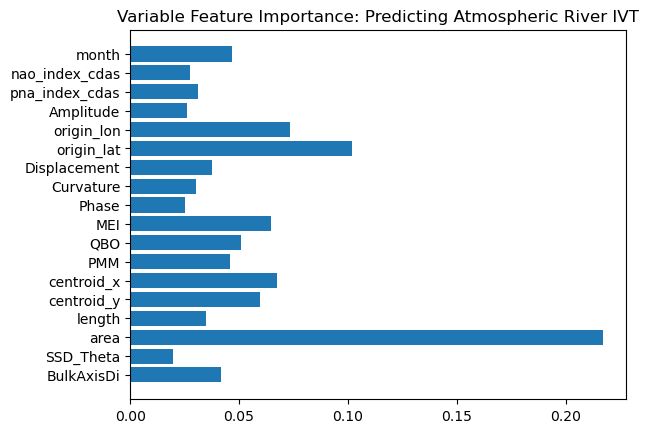

In [53]:
# 
# Plot the variable importances as a bar plot, showing their names and associated drops in model accuraycy
plt.barh(automl.feature_names_in_,automl.feature_importances_)
plt.title('Variable Feature Importance: Predicting Atmospheric River IVT') # Give it a useful title
plt.show()

### Generate predictions on the testing split dataset and evaluate the model's performance

In [54]:
#
# Use the FLAML's pipeline to generate predictions on the testing dataset
y_pred = automl.predict(X_test)

#
# Evaluation metrics!
print('r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test)) # Coefficient of determination
print('mse', '=', sklearn_metric_loss_score('mse', y_pred, y_test)) # Mean Squared Error
print('mae', '=', sklearn_metric_loss_score('mae', y_pred, y_test)) # Mean Absolute Error

Predicted labels [490.54572 411.17575 353.86014 ... 459.1916  363.59314 681.74194]


### Compare FLAML's regression results to a standard XGboosted regression tree

In [56]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
from flaml.automl.ml import sklearn_metric_loss_score

print('default xgboost r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test)) # We can see that it's not as good as the model setup with FLAML's hyperparameter search

default xgboost r2 = 0.7250720006013244


### Generate a performance diagram to evaluate the XGboosted regression tree's results 

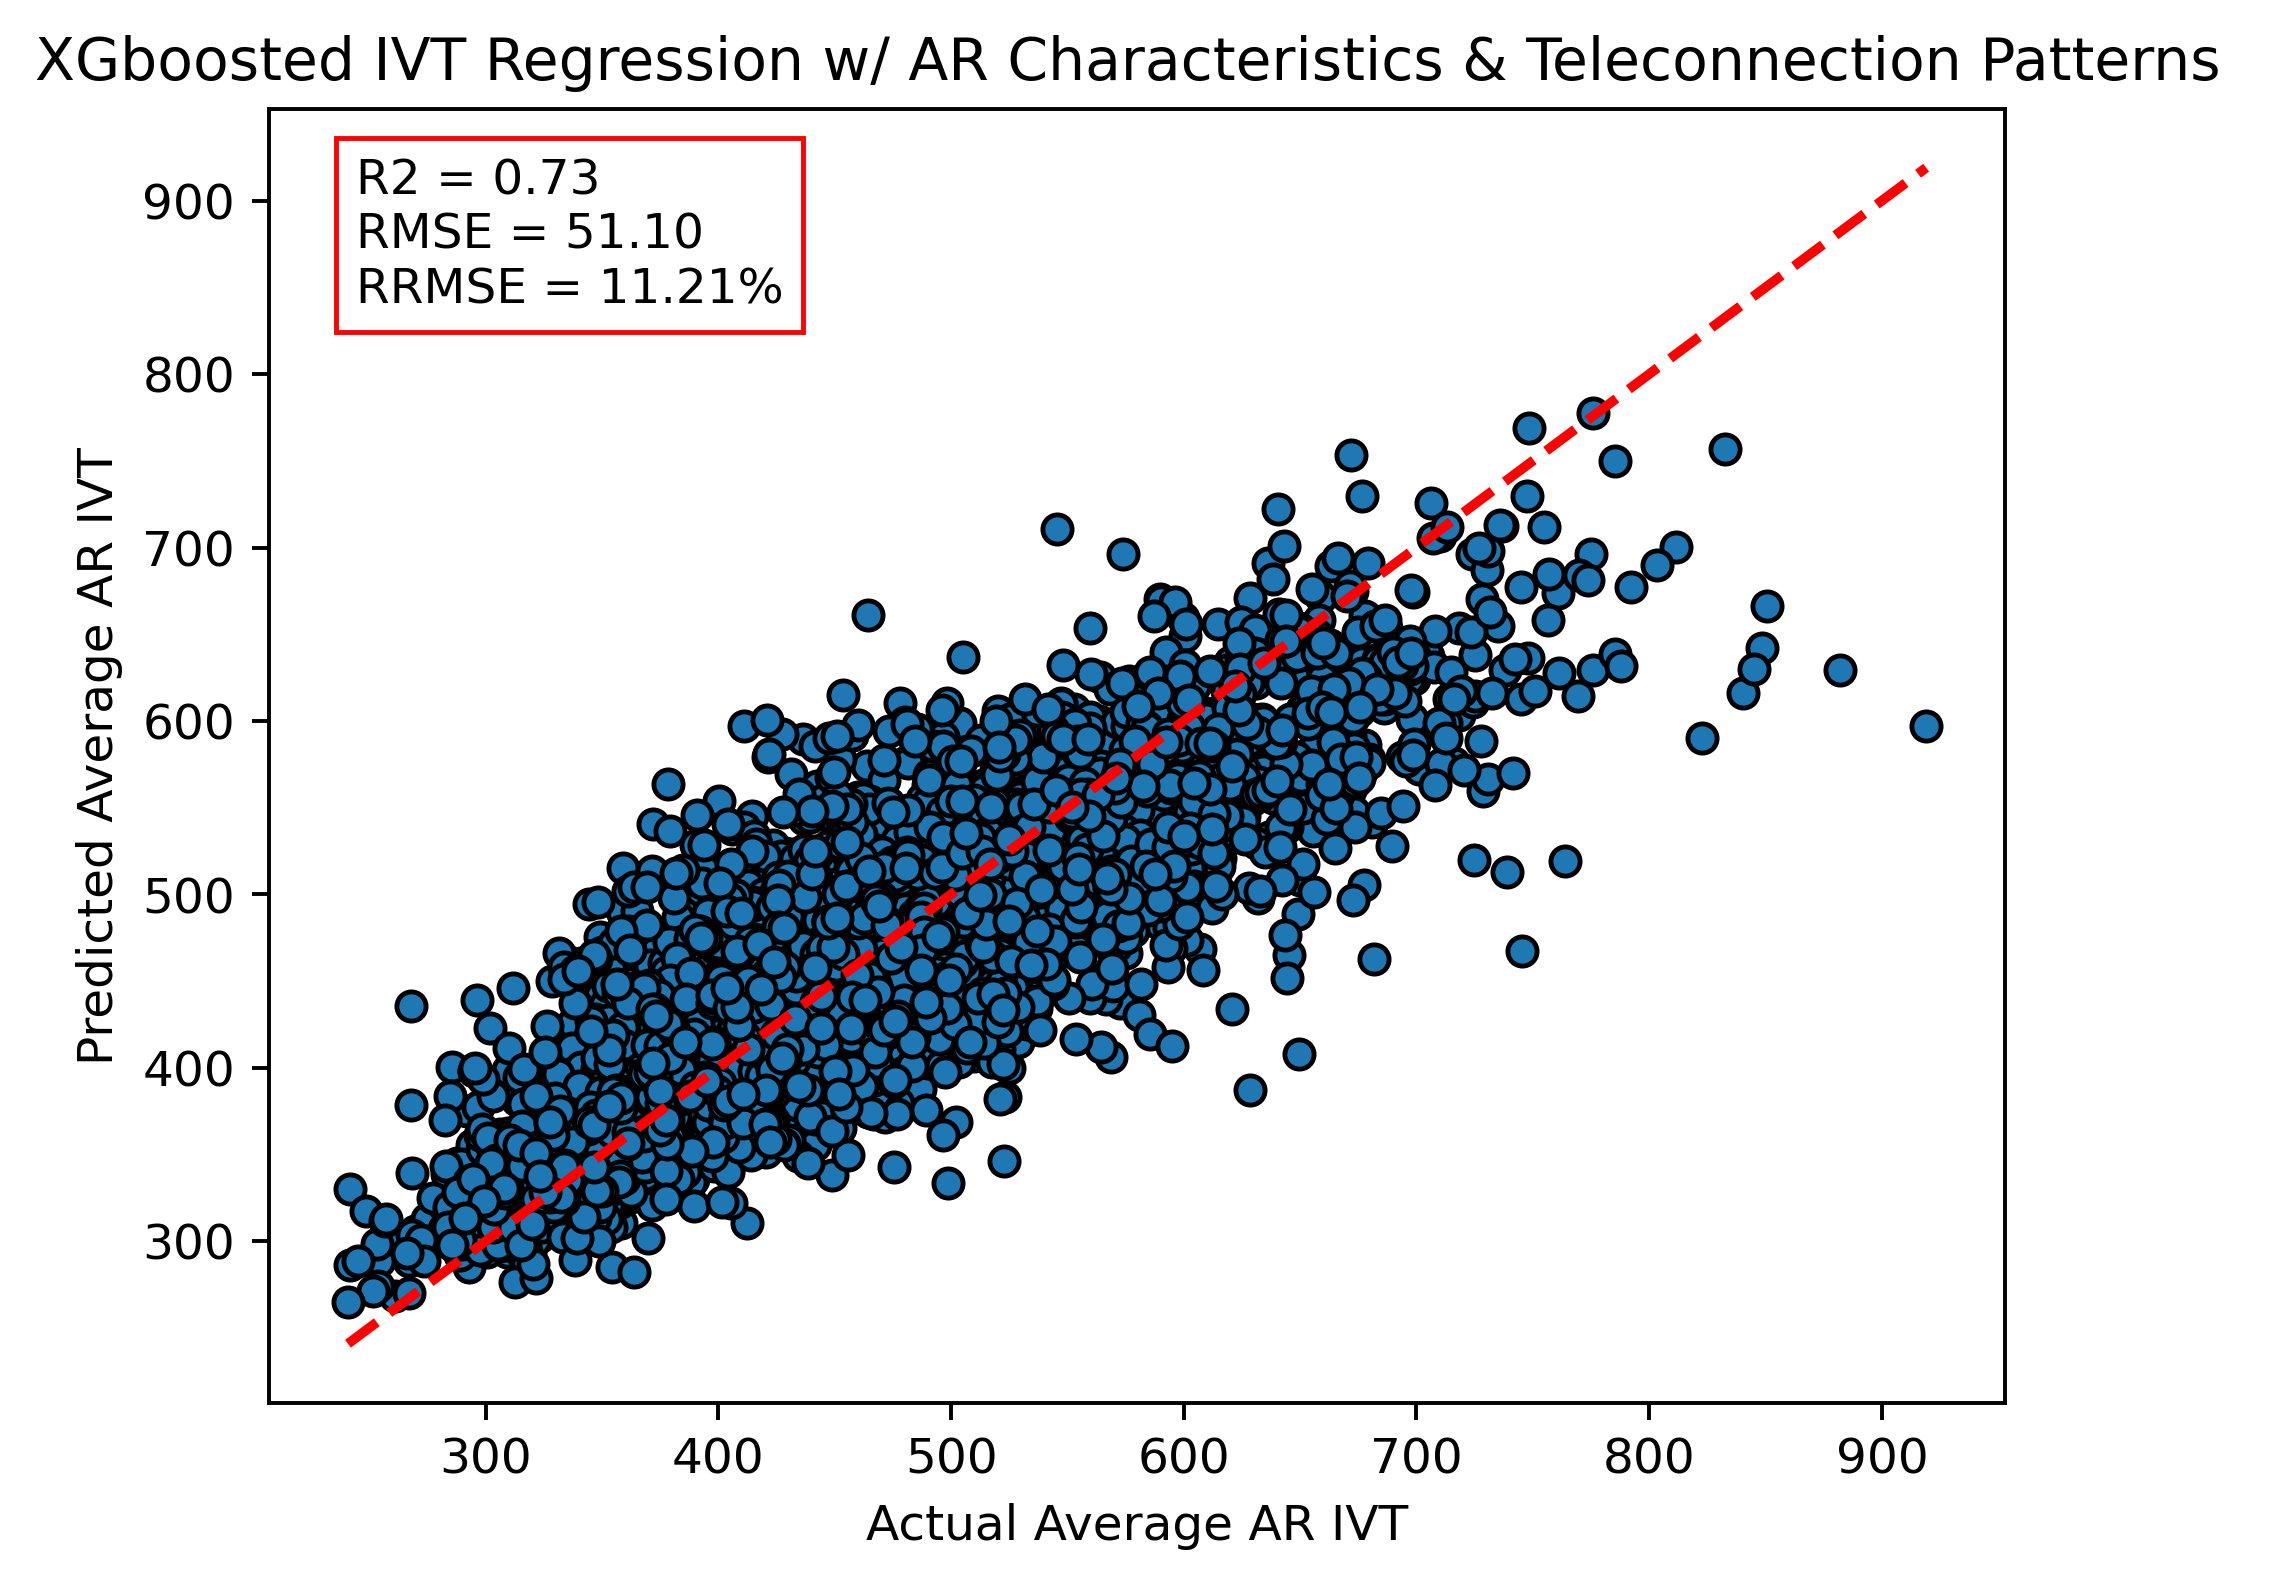

In [62]:
scatter_plot(y_test, y_pred, 'XGboosted IVT Regression w/ AR Characteristics & Teleconnection Patterns ') # EZPZ